<a href="https://colab.research.google.com/github/kmayutrisna/SA_IMDB/blob/main/4_IMDB_bert_CNN_Base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 61.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 28.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 103.6 MB/s eta 0:00:00


In [3]:
#DATA PREPARATION
# Importing essential libraries and functions
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from numpy import array
import tensorflow as tf

from keras.preprocessing.text import one_hot, Tokenizer
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense
from transformers import BertTokenizer
from transformers import TFBertModel
from tensorflow.keras.optimizers import Adam

**DATA COLLECTION**

In [4]:
#Get the dataset from gdrive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#Display top of data
data =pd.read_csv("drive/My Drive/data/IMDB Dataset.csv")
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [6]:
#Display shape and data info
data.review.shape
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [7]:
# Checking for missing values
data.isnull().values.any()

False

**DATA PREPROCESSING**

In [8]:
TAG_RE = re.compile(r'<[^>]+>')
def remove_tags(text):
  '''Removes HTML tags: replaces anything between opening and closing <> with empty space'''
  return TAG_RE.sub('', text)

In [9]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [10]:
def preprocess_text(sen):
     '''Cleans text data up, leaving only 2 or more char long non-stepwords composed of A-Z & a-z only
     in lowercase'''
    
     sentence = sen.lower()

      #Remove html tags
     sentence = remove_tags(sentence)

      #Remove punctuations and numbers
     sentence = re.sub('[^a-zA-Z]', ' ', sentence)

      #Single character removal
     sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)  # When we remove apostrophe from the word "Mark's", the apostrophe is replaced by an empty space. Hence, we are left with single character "s" that we are removing here.

      #Remove multiple spaces
     sentence = re.sub(r'\s+', ' ', sentence)  # Next, we remove all the single characters and replace it by a space which creates multiple spaces in our text. Finally, we remove the multiple spaces from our text as well.

     # Remove Stopwords
     pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
     sentence = pattern.sub('', sentence)

     return sentence

In [11]:
# Calling preprocessing_text function on movie_reviews

#X = []
#sentences = list(data['review'])
#for sen in sentences:
 #   X.append(preprocess_text(sen))

#Display datas that has been cleaned
data['processed'] = data['review'].apply(lambda x: preprocess_text(x))
data.head()

,review,sentiment,processed
0,One of the other reviewers has mentioned that ...,positive,one reviewers mentioned watching oz episode ho...
1,A wonderful little production. <br /><br />The...,positive,wonderful little production filming technique ...
2,I thought this was a wonderful way to spend ti...,positive,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,negative,basically family little boy jake thinks zombie...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,petter mattei love time money visually stunnin...


In [12]:
#Data Processing
#Provide a sentiment class with a label. 1 if positive and 0 if negative.
data['Label'] = data['sentiment'].apply(lambda x: 0 if x == 'negative' else 1)
data.head()

,review,sentiment,processed,Label
0,One of the other reviewers has mentioned that ...,positive,one reviewers mentioned watching oz episode ho...,1
1,A wonderful little production. <br /><br />The...,positive,wonderful little production filming technique ...,1
2,I thought this was a wonderful way to spend ti...,positive,thought wonderful way spend time hot summer we...,1
3,Basically there's a family where a little boy ...,negative,basically family little boy jake thinks zombie...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,petter mattei love time money visually stunnin...,1


**TOKENIZER AND SPLIT DATASET**

In [13]:
#Tokenize the text, Any unknown word will be replaced by oov_token
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
tokenizer = Tokenizer(oov_token="<OOV>")

In [14]:
# Let's say we want to split the data in 80:10:10 for train:valid:test dataset
train_size=0.8
X = data['processed']
y = data['Label']

# In the first step we will split the data in training and remaining dataset
X_train, X_rem, y_train, y_rem = train_test_split(X,y, train_size=0.8)

# Now since we want the valid and test size to be equal (10% each of overall data). 
# we have to define valid_size=0.5 (that is 50% of remaining data)
test_size = 0.5
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5)

print(X_train.shape), print(y_train.shape)
print(X_valid.shape), print(y_valid.shape)
print(X_test.shape), print(y_test.shape)

(40000,)
(40000,)
(5000,)
(5000,)
(5000,)
(5000,)


(None, None)

In [15]:
# Tokenize the text using BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
X_train = X_train.apply(lambda x: tokenizer.encode(x, add_special_tokens=True))
X_test = X_test.apply(lambda x: tokenizer.encode(x, add_special_tokens=True))
X_valid = X_valid.apply(lambda x: tokenizer.encode(x, add_special_tokens=True))

Token indices sequence length is longer than the specified maximum sequence length for this model (558 > 512). Running this sequence through the model will result in indexing errors


In [16]:
vocab_size = 10000
#embedding_dim = 100
max_length = 100
trunc_type = 'post'
oov_tok = '<OOV>'
padding_type = 'post'

In [18]:
# Pad the sequences to have the same length
#max_len = 100
X_train = pad_sequences(X_train, maxlen=max_length, padding='post')
X_test = pad_sequences(X_test, maxlen=max_length, padding='post')
X_valid = pad_sequences(X_valid, maxlen=max_length, padding='post')

**1-D Convolutions over text**

In [19]:
from tensorflow.keras.layers import Dense, Embedding,GlobalMaxPooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Embedding

base_model = Sequential()
base_model.add(Embedding(len(tokenizer.vocab), 128, input_length=max_length))
#base_model.add(Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=max_length, trainable=False))
#base_model.add(Embedding(vocab_size, embedding_dim, input_length = max_length))
base_model.add(Conv1D(64, 5, activation='relu'))
base_model.add(GlobalMaxPooling1D())
base_model.add(Flatten())
base_model.add(Dense(units=64, activation='relu'))
base_model.add(Dropout(0.3))
base_model.add(Dense(units=1, activation='sigmoid'))


In [20]:
# Model compiling
from tensorflow import keras
from tensorflow.keras.metrics import AUC

base_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
#base_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc', keras.metrics.AUC(curve='ROC'), keras.metrics.AUC(curve='PR')])

print(base_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 128)         3906816   
                                                                 
 conv1d (Conv1D)             (None, 996, 64)           41024     
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                        

In [21]:
# Train model
history = base_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_valid, y_valid))

#loss, acc, auc_roc, auc_pr = base_model.evaluate(val_padded, y_valid, verbose=0)
#print('Validation accuracy: ', acc)
#print('Validation AUC-ROC: ', auc_roc)
#print('Validation AUC-PR: ', auc_pr)

Epoch 1/10
1250/1250 [==============================] - 180s 134ms/step - loss: 0.3577 - acc: 0.8342 - val_loss: 0.2699 - val_acc: 0.8866
Epoch 2/10
1250/1250 [==============================] - 61s 49ms/step - loss: 0.1305 - acc: 0.9535 - val_loss: 0.2846 - val_acc: 0.8888
Epoch 3/10
1250/1250 [==============================] - 35s 28ms/step - loss: 0.0220 - acc: 0.9942 - val_loss: 0.4239 - val_acc: 0.8824
Epoch 4/10
1250/1250 [==============================] - 24s 19ms/step - loss: 0.0047 - acc: 0.9988 - val_loss: 0.5590 - val_acc: 0.8730
Epoch 5/10
1250/1250 [==============================] - 24s 20ms/step - loss: 0.0033 - acc: 0.9991 - val_loss: 0.6365 - val_acc: 0.8738
Epoch 6/10
1250/1250 [==============================] - 17s 14ms/step - loss: 0.0217 - acc: 0.9916 - val_loss: 0.5561 - val_acc: 0.8788
Epoch 7/10
1250/1250 [==============================] - 17s 14ms/step - loss: 0.0085 - acc: 0.9971 - val_loss: 0.6547 - val_acc: 0.8788
Epoch 8/10
1250/1250 [========================

In [22]:
# Predicting on the Test dataset.
y_pred = base_model.evaluate(X_test, y_test)
#y_pred = base_model.predict(test_padded, y_test).flatten()

157/157 [==============================] - 1s 7ms/step - loss: 0.7219 - acc: 0.8802


In [23]:
# Model Performance

print("Test Score:", y_pred[0])
print("Test Accuracy:", y_pred[1])

Test Score: 0.7219156622886658
Test Accuracy: 0.8802000284194946


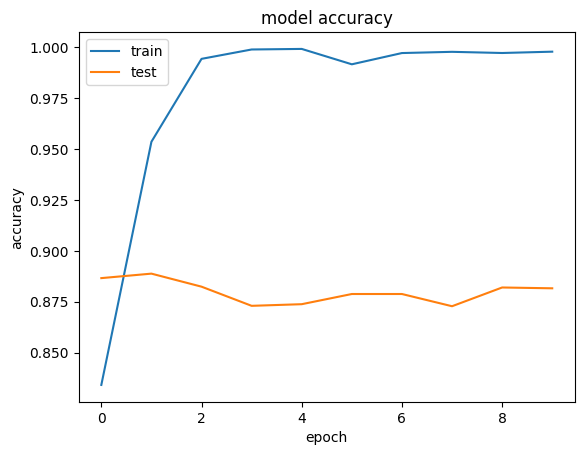

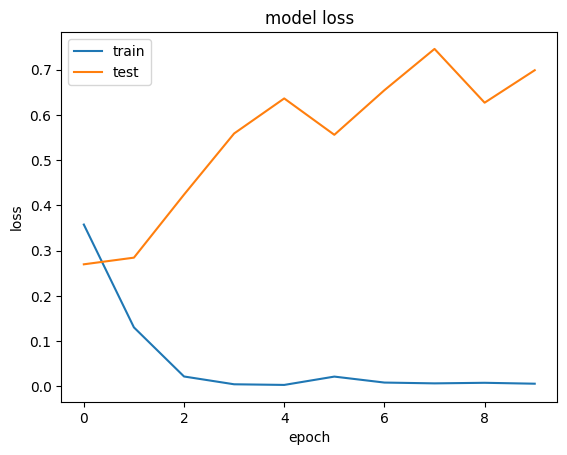

In [24]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

In [25]:
from sklearn.metrics import confusion_matrix, classification_report

def ConfusionMatrix(y_pred, y_test):
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

157/157 [==============================] - 2s 9ms/step


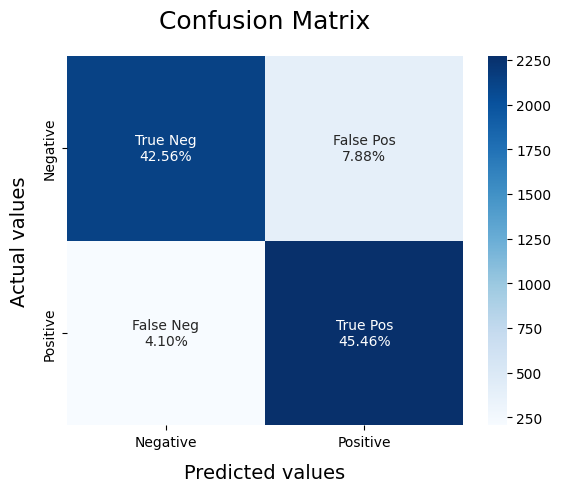

In [27]:
import seaborn as sns
# Predicting on the Test dataset.
y_pred = base_model.predict(X_test)

# Converting prediction to reflect the sentiment predicted.
y_pred = np.where(y_pred>=0.5, 1, 0)

# Printing out the Evaluation metrics. 
ConfusionMatrix(y_pred, y_test)

In [28]:
# Print the evaluation metrics for the dataset.
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9121    0.8438    0.8766      2522
           1     0.8523    0.9173    0.8836      2478

    accuracy                         0.8802      5000
   macro avg     0.8822    0.8805    0.8801      5000
weighted avg     0.8825    0.8802    0.8801      5000

